# Calculating correlations between landscape wetness and stream gauges <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Understanding the movement of floodwater throughout the landscape is critical to managing and tracking water in our important river basins. 
Water is often injected into a region to support agriculture and the environment, but it can be difficult to understand whether this water made it to its intended location. 
Direct measurements of water inundation and flooding are not usually available. 
Developing this understanding is especially important in the dry Australian climate.

### Digital Earth Australia use case
Earth observation data could help track floodwater moving throughout the landscape. Methods like [Tasseled-Cap Wetness (TCW)](https://doi.org/10.1109/TGRS.1984.350619) and [Water Observations from Space (WOfS)](https://doi.org/10.1016/j.rse.2015.11.003) can be used to estimate coverage of water in the landscape from satellite imagery, and this could be used both to build models on water distribution as well as track historical water movements.

### Description
Tracking floodwater is hard though as satellite data are not always available and the flow of water through the landscape can be very complicated. 
It would be really nice if we could use stream gauges as a proxy for floodwater levels away from the streams they probe. 
Stream gauge data are readily available for many rivers and streams throughout the continent, and the data are well-sampled and reliable. 
This notebook estimates the linear correlation between TCW at a location and the height of nearby stream gauges. 
The hope is that by finding such correlations, stream gauge data could be used to provide insights into the spatial footprint of flood events.

## Getting started

Set the analysis parameters and then run all cells.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datacube
from tqdm.auto import tqdm
import geopandas as gpd
import shapely.geometry
import scipy.stats
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.bom import get_stations, get_station_data
from dea_tools.datahandling import load_ard
from dea_tools.temporal import lag_linregress_3D
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
create_local_dask_cluster()

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37927 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Wetness_stream_gauge_correlations")

### Analysis parameters

Specify a region to analyse:

In [3]:
# Murray @ Colignan
southwest = -34.58, 142.39
northeast = -34.55, 142.43

# Murray @ Gulpa
# southwest = -35.87, 144.96
# northeast = -35.84, 145.03

ylim, xlim = zip(southwest, northeast)

## Querying the BOM

The Bureau of Meteorology keeps stream gauge data. Get all stream gauge stations:

In [4]:
stations = get_stations()
assert stations, 'No stations retrieved from BOM'

Then find all the stations in our analysis region:

In [5]:
stations_in_range = [
    s for s in stations
    if s.pos and ylim[0] <= s.pos[0] <= ylim[1] and xlim[0] <= s.pos[1] <= xlim[1]
]

In [6]:
print('Found', len(stations_in_range), f'station{"s" if len(stations_in_range) != 1 else ""} in range')

Found 2 stations in range


Get stream data for each station:

In [7]:
station_data = [get_station_data(s) for s in stations_in_range]

Filter out stations without any data:

In [8]:
stations_in_range = [s for d, s in zip(station_data, stations_in_range) if len(d.index)]
station_data = [d for d in station_data if len(d.index)]
print('Found', len(stations_in_range), f'station{"s" if len(stations_in_range) != 1 else ""} with data')

Found 2 stations with data


Then interpolate each gauge to daily.

In [9]:
station_data = [d.resample("1D").mean() for d in station_data]

Find the most recent first observation amongst all stations, then then crop every data series to that

In [10]:
latest = max(d.index.min() for d in station_data)
station_data = [d[d.index >= latest] for d in station_data]

Now all stations have data over the same time range.

## Load Tasselled Cap Wetness data 

Tasselled Cap Wetness (TCW) is good at detecting water when mixed with vegetation, and we expect wet vegetation on floodplains.

Load Landsat data so we can calculate TCW. 
Downsample to 100m: we don't need fine details if we're analysing entire floodplains, and this dramatically speeds up our analysis.

> **Note**: This step may take several minutes to complete.
To view how this the load is progressing, click the `dask` client dashboard link under the Getting Started section (e.g. `/user/username/proxy/8787/status`)

In [11]:
ls = load_ard(
    dc,
    products=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3"],
    time=(latest, "2020-10"),
    min_gooddata=0.80,
    x=xlim,
    y=ylim,
    output_crs="EPSG:3577",
    resolution=(-100, 100),
    resampling="bilinear",
    measurements=[
        "nbart_red",
        "nbart_blue",
        "nbart_green",
        "nbart_nir",
        "nbart_swir_1",
        "nbart_swir_2",
    ],
    dask_chunks={"time": 1, "x": 3000, "y": 3000},
).load()

Finding datasets
    ga_ls5t_ard_3


/home/jovyan/dev/dea-notebooks/Real_world_examples/../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 442 out of 768 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Returning 442 time steps as a dask array


Then calculate TCW:

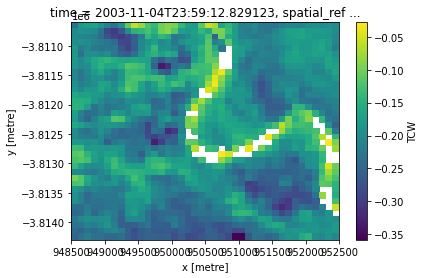

In [12]:
tcw = calculate_indices(ls, "TCW", "ga_ls_3")
tcw.TCW.isel(time=101).plot()

### Reindex the stream gauge data to the TCW data

Align the stream gauge data with the TCW data by reindexing them so their dates match.

In [13]:
station_data_tcw = []
for i in range(len(station_data)):
    times = np.sort(np.unique(np.concatenate([tcw.time, station_data[i].index])))
    station_data_tcw.append(
        station_data[i]
        .reindex(times)
        .interpolate(method="nearest")
        .reindex(tcw.time.values)
    )

Then convert this into an `xarray.DataArray`:

In [14]:
station_data_xr = []
for d in station_data_tcw:
    d.index.name = 'time'
    da = xr.DataArray(d.Value)
    station_data_xr.append(da)

### Normalise the TCW and stream gauge data

Prepare the data for correlation estimation.

Divide the stream gauges by their maximum values to limit their range from 0 to 1:

In [15]:
station_data_xr = [d / d.max() for d in station_data_xr]

Repeat for the TCW data:

In [16]:
tcw_values = tcw.TCW
tcw_values = tcw_values / abs(tcw_values).max(axis=0)

## Regression between each time series

Compute a linear regression between the stream gauge and TCW time series for each gauge and each pixel.


In [17]:
lr = [lag_linregress_3D(d, tcw_values) for d in station_data_xr]

/env/lib/python3.8/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Then we can plot the slopes:

In [18]:
station_locations = gpd.GeoDataFrame(
    geometry=[shapely.geometry.Point(s.pos[::-1]) for s in stations_in_range],
    crs="EPSG:4326",
).to_crs(tcw.crs)

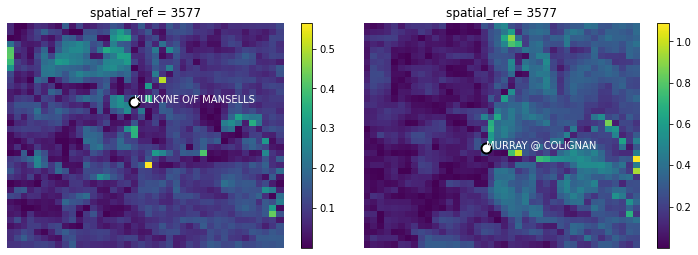

In [19]:
def plot_station_correlations(values, vmin=0, vmax=1, cmap="viridis"):
    plt.figure(figsize=(15, 20))
    for i in range(len(station_data)):
        ax = plt.subplot(6, 3, i + 1)
        values[i].plot(ax=ax)
        ax.scatter(
            station_locations.iloc[i].geometry.x,
            station_locations.iloc[i].geometry.y,
            edgecolor="k",
            facecolor="w",
            s=100,
            linewidth=2,
        )
        ax.axis("off")
        ax.text(
            station_locations.iloc[i].geometry.x,
            station_locations.iloc[i].geometry.y,
            stations_in_range[i].name,
            c="white",
        )
    plt.tight_layout()
    
plot_station_correlations([abs(l.cor) for l in lr])

There are two stream gauges in this region. 
One is off-stream and one is on-stream. 
The on-stream gauge is clearly related to the TCW values of the eastern half of the region.

## Randomly shift the data to estimate how much correlation is coincidental

Estimate how much correlation we should expect just by chance if there is no real correlation at all between the time series. 
To do this, shift the TCW time series so that there should be no correlation. 
Then repeat the above analysis. 
The amount of correlation detected is the expected coincidental correlation.

/env/lib/python3.8/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


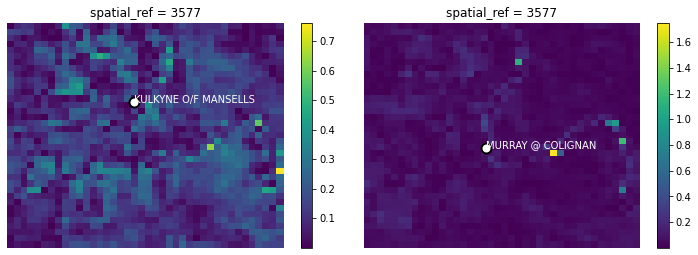

In [20]:
lr_shifted = [lag_linregress_3D(d, tcw_values, lagx=100) for d in station_data_xr]
plot_station_correlations([abs(l.cor) for l in lr_shifted])

Print the random correlations for each site:

In [21]:
rand_corr = [abs(l.cor).mean().values for l in lr_shifted]

print("Random correlation:")
for i in range(len(stations_in_range)):
    print(stations_in_range[i].name, rand_corr[i].round(2))

Random correlation:
KULKYNE O/F MANSELLS 0.13
MURRAY @ COLIGNAN 0.06


We can interpret this as a noise level and use it to mask insignificant correlations, which we will say are pixels with correlations less than 3 times the noise level:

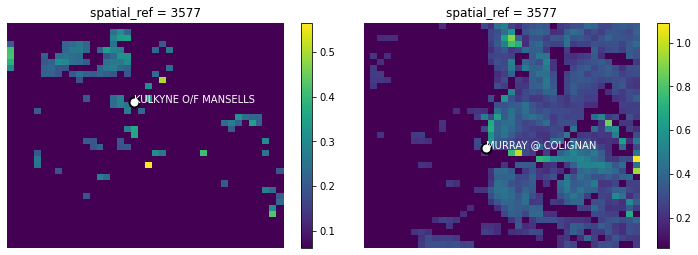

In [22]:
plot_station_correlations(
    [xr.where(abs(l.cor) < 3 * rand_corr[i], rand_corr[i], abs(l.cor)) for l in lr]
)

The detected correlations for the on-stream gauge seem significant.

## Conclusion

This is a very simple way of estimating the correlation between stream gauges and the surrounding landscape. Future work should investigate non-linear correlations, potential lag between stream gauges and landscape changes, and merging together identical or near-identical stream gauges (e.g. neighbouring gauges on the same river).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:**

In [23]:
datacube.__version__

'1.8.5'

## Tags